<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-06/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Selection and Preprocessing:

For this task, I have selected the xl-sum dataset, which consists of BBC articles and summaries.

Source: https://paperswithcode.com/dataset/xl-sum

In [1]:
!pip install datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import load_dataset

from google.colab import drive

dat = load_dataset('csebuetnlp/xlsum', 'english')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
train = dat['train'].to_pandas()
test = dat['test'].to_pandas()

print(train.shape, test.shape)

(306522, 5) (11535, 5)


In [4]:
print(train.head())

                                       id  \
0                       uk-wales-56321577   
1  uk-scotland-highlands-islands-11069985   
2               uk-england-leeds-45776523   
3                world-us-canada-51010441   
4       uk-scotland-glasgow-west-52274685   

                                                 url  \
0         https://www.bbc.com/news/uk-wales-56321577   
1  https://www.bbc.com/news/uk-scotland-highlands...   
2  https://www.bbc.com/news/uk-england-leeds-4577...   
3  https://www.bbc.com/news/world-us-canada-51010441   
4  https://www.bbc.com/news/uk-scotland-glasgow-w...   

                                               title  \
0  Weather alert issued for gale force winds in W...   
1   Huge tidal turbine installed at Orkney test site   
2  Leeds stabbing: Man attacked outside betting shop   
3  Could killing of Iranian general help Trump ge...   
4  Coronavirus: 'I've moved out to protect my fam...   

                                             summary  \

In [5]:
train = train.drop(columns=['id', 'url', 'title'])
test = test.drop(columns=['id', 'url', 'title'])


In [6]:
print(train.head(), test.head())

                                             summary  \
0  Winds could reach gale force in Wales with sto...   
1  The massive tidal turbine AK1000 has been inst...   
2  A man has been stabbed in broad daylight outsi...   
3  It was inevitable that the fallout from the US...   
4  Week four of social distancing is starting to ...   

                                                text  
0  The Met Office has issued a yellow weather war...  
1  Atlantis Resources unveiled the marine energy ...  
2  Police were called to the scene outside the Co...  
3  Anthony ZurcherNorth America reporter@awzurche...  
4  By Debbie JacksonBBC Scotland But while most o...                                                summary  \
0  Donald Trump campaigned on becoming a presiden...   
1  The Welsh Government "would probably" take the...   
2  A university has mistakenly emailed hundreds o...   
3  Some progress has been made in encouraging gir...   
4  The president of business organisation, the CB... 

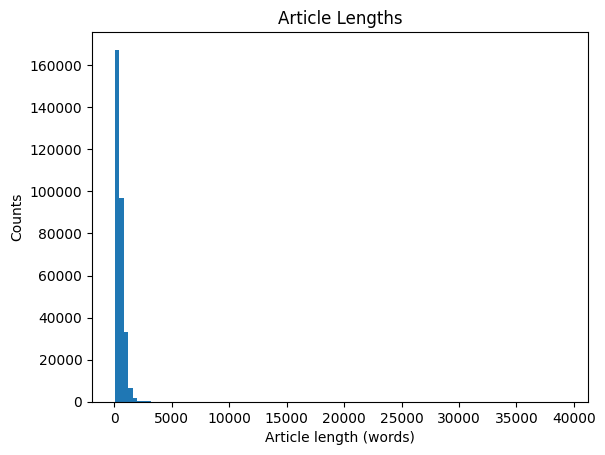

In [7]:
plt.hist([len(t.split(' ')) for t in train.text], bins=100)
plt.title("Article Lengths")
plt.ylabel("Counts")
plt.xlabel("Article length (words)")
plt.show()

## Dataset Splitting

Here, I filter any articles that are more than 2000 words out, and randomly sample 90 samples from training set and 10 samples from the test set.

In [21]:
train = train.sample(frac=1).reset_index(drop=True)
train = train[:30000]

train = train[train['text'].apply(lambda x: len(x.split(" ")) <= 2000)]
test = test[test['text'].apply(lambda x: len(x.split(" ")) <= 2000)]

train = train.sample(90).reset_index(drop=True)
test = test.sample(10).reset_index(drop=True)

In [22]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

## Fine-tuning model:

Here, I still update every batch, but use a very small learning rate. Since the model is already pre-trained, only very small tweaks are needed to fine-tune to my specific task and dataset.

In [23]:
from torch import optim
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

drive.mount('/content/drive')

def train_Bart(data, labels, model, tokenizer, epochs = 20, lr = 0.00001):
  model.train()
  optimizer = optim.AdamW(model.parameters(), lr)

  for e in range(epochs):
    losses = []
    i = 0
    for b in range(np.shape(data)[0]):
      d = [data[b]]
      t = [labels[b]]
      batch = tokenizer(d, padding = 'longest', max_length = 1024, truncation = True)
      attn = torch.LongTensor(batch['attention_mask'])
      batch = torch.LongTensor(batch['input_ids'])
      tar = torch.LongTensor(tokenizer(text_target = t, max_length = 1024, padding = 'longest', truncation = True)['input_ids'])
      model_output = model(batch, attn, labels = tar)
      loss = model_output.loss
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    print("Epoch {} | Loss {:.5f}".format(e, np.mean(losses)))

  torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/fine-tuned-BART.pt')

train_Bart(list(train.text), list(train.summary), model, tokenizer)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 0 | Loss 2.92649
Epoch 1 | Loss 2.27942
Epoch 2 | Loss 1.96290
Epoch 3 | Loss 1.62935
Epoch 4 | Loss 1.36014
Epoch 5 | Loss 1.15798
Epoch 6 | Loss 0.95532
Epoch 7 | Loss 0.81989
Epoch 8 | Loss 0.68593
Epoch 9 | Loss 0.67416
Epoch 10 | Loss 0.51413
Epoch 11 | Loss 0.41764
Epoch 12 | Loss 0.37091
Epoch 13 | Loss 0.30395
Epoch 14 | Loss 0.26159
Epoch 15 | Loss 0.23527
Epoch 16 | Loss 0.19676
Epoch 17 | Loss 0.18259
Epoch 18 | Loss 0.18661
Epoch 19 | Loss 0.15670


In [24]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

# Load fine-tuned model
drive.mount('/content/drive')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/fine-tuned-BART.pt'))

generated_summaries = []

model.eval()
with torch.no_grad():
  for b in range(10):
    d = list(test.text)[b:(b+1)]
    t = list(test.summary)[b:(b+1)]
    batch = tokenizer(d, padding = 'longest', max_length = 1024, truncation = True)
    tar = torch.LongTensor(tokenizer(text_target = t, max_length = 1024, padding = 'longest', truncation = True)['input_ids'])
    batch = torch.LongTensor(batch['input_ids'])
    model_output = model(batch, labels=tar)
    print("Loss: {}".format(model_output.loss.item()))
    print("Predicted summary: {}".format([tokenizer.decode(t[1:]) for t in torch.argmax(model_output.logits, dim=-1)]))
    print("Actual summary: {}".format(t))
    generated_summaries.append([tokenizer.decode(t[1:]) for t in torch.argmax(model_output.logits, dim=-1)][0].replace('</s>', '\n'))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loss: 4.090744972229004
Predicted summary: ['A has detained into of people plot to a military police to a S of a trial. Ankara.</s>']
Actual summary: ['Turkey has marched dozens of coup suspects past a hostile crowd at the start of their trial near Ankara.']
Loss: 2.9525771141052246
Predicted summary: ['A cat named been after being shot by a laser gunguided rifle rifle by the homeshickal"", terror", a RoyalSPCA has said.</s>']
Actual summary: ['A cat has died after being shot with a laser-sighted air rifle in a "brutal act of cruelty", the RSPCA has said.']
Loss: 3.2154860496520996
Predicted summary: ['Tric on a Swansea for Swansea Swansea800bn Swansea Bay lagoon project is beingcatperateately important", a Welsh government Secretary has said.</s>']
Actual summary: ['Agreement on the subsidy for the £1bn Swansea tidal lagoon project is "desperately needed", t

In [12]:
!pip install rouge-score

In [25]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

for i in range(10):
  print(sentence_bleu([list(test.text)[i]], generated_summaries[i]))
  scores = rouge_scorer.score(list(test.text)[i], generated_summaries[i])

  for key in scores:
      print(f'{key}: {scores[key]}')
  print()

1.0608439349561503e-18
rouge1: Score(precision=0.8888888888888888, recall=0.02680067001675042, fmeasure=0.05203252032520325)
rouge2: Score(precision=0.11764705882352941, recall=0.003355704697986577, fmeasure=0.0065252854812398045)
rougeL: Score(precision=0.6666666666666666, recall=0.020100502512562814, fmeasure=0.039024390243902446)

0.0014304547408874855
rouge1: Score(precision=0.42857142857142855, recall=0.0625, fmeasure=0.10909090909090909)
rouge2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
rougeL: Score(precision=0.2857142857142857, recall=0.041666666666666664, fmeasure=0.07272727272727272)

9.408616188408798e-10
rouge1: Score(precision=0.75, recall=0.02717391304347826, fmeasure=0.05244755244755245)
rouge2: Score(precision=0.2631578947368421, recall=0.009074410163339383, fmeasure=0.01754385964912281)
rougeL: Score(precision=0.55, recall=0.019927536231884056, fmeasure=0.03846153846153846)

3.118394168440332e-08
rouge1: Score(precision=0.7586206896551724, recall=0.039285714285714

When fine-tuning a model, it seems very important to either not update the weights every epoch, or use a sufficiently low learning rate. At first, I tried fine-tuning using a normal $1*10^{-3}$ for every single sample, but it ended up overfitting dramatically. It seems like, in general, the recall for the Rouge scores are significantly lower than the precision scores. The BLEU scores also seem very low, and I'm not really sure why. Generally, the high ROUGE precision (relative to recall) imply that most of the terms in the generated summary are also in the candidate summary, while the opposite is not neccesarily true. In the generated summaries, it seems like many terms are erroneously repeated, which is probably why an artificially high ROUGE precision score is reported. I'm not really certain how my results are impacted by the choice of LLM. I imagine a larger model (like facebook-large) would perform better, and a model more taylored towards text summarization would also perform better, but overall this fine-tuned model seems to do at least okay at text summarization. By reading the generated summaries, I can at least get a gist of the actual summary, even if it doesn't make much grammatical sense.